In [1]:
#python deep_dream.py path_to_your_base_image.jpg prefix_for_results
#python deep_dream.py img/mypic.jpg results/dream

from __future__ import print_function

from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K
from keras.preprocessing import image
import keras


import tensorflow as tf

/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## load striped CAV, layer 9
import os
import cav
working_dir = '/home/tyler/Desktop/tcav_on_azure'
subpath = 'striped_sub_1-random500_0-mixed9'
cav_path = 'cavs/' + subpath + '-linear-0.1.pkl'
path = os.path.join(working_dir, cav_path)

this_cav = cav.CAV.load_cav(path)
layer_9_cav = this_cav.cavs[0]

In [3]:
K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',include_top=False)
dream = model.input
print('Model loaded.')

Instructions for updating:
Colocations handled automatically by placer.
Model loaded.


In [4]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.05  # Gradient ascent step size
num_octave = 1  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 50  # Number of ascent steps per scale
max_loss = 100000000000

base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/horse_sub_1/img100.jpg'
#result_prefix = '/home/tyler/Desktop/tcav_on_azure/results/test'

settings = {
    'features': {
        'mixed9': 10
    },}

In [7]:
img = preprocess_image(base_image_path)


In [23]:
layer_9_cav = layer_9_cav.reshape(-1,1)
layer_9_cav_K = K.constant(layer_9_cav)

layer_dict = dict([(layer.name, layer) for layer in model.layers])

sess = K.get_session()

# Define the loss.

#loss = K.variable(0.)
#for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
#    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
#    coeff = settings['features'][layer_name]
#    x = layer_dict[layer_name].output
#    acts = x
    # We avoid border artifacts by only involving non-border pixels in the loss.
#    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    #loss += 3
#    if K.image_data_format() == 'channels_first':
#        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
#    else:
#        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
#grads = K.gradients(loss, model.input)[0]
# Normalize gradients.
#grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value of the loss and gradients given an input image.
#outputs = [loss, grads]

#fetch_loss_and_grads = K.function([model.input], outputs)


loss_2 = K.variable(0.)
for layer_name in settings['features']:
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    acts = layer_dict[layer_name].output
    
    #flat_act = np.reshape(np.asarray(acts).squeeze(), -1)
    #flat_act_norm = keras.utils.normalize(flat_act)
    #loss2 = euclidean_distance(vec_norm(layer_9_cav),flat_act_norm)
    
    #loss_2 += K.sum(K.square(K.reshape(acts,(131072,)) - layer_9_cav_K))
    #loss_2 += K.dot(K.reshape(acts,(1,131072)),K.transpose(layer_9_cav_K))
    loss_2 -= K.dot(K.reshape(acts,(1,131072)),layer_9_cav_K)

    #loss_2 = layer_9_cav_K


#loss_2 = loss
grads_2 = K.gradients(loss_2, model.input)[0]
grads_2 /= K.maximum(K.mean(K.abs(grads_2)), K.epsilon())

outputs_2 = [loss_2, grads_2, acts]
fetch_loss_and_grads_2 = K.function([model.input], outputs_2)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads_2([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

#def eval_loss_and_grads(x):
#    outs = fetch_loss_and_grads(x)
#    loss_value = get_loss(x)
#    grads = K.gradients(loss, model.input)[0]
#    grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
#    return loss_value, grads

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        #print(loss.eval())
        x -= step * grad_values
    return x

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

In [24]:
tf.logging.set_verbosity(0)

img_pic = image.load_img(base_image_path, target_size=(299, 299))
img = image.img_to_array(img_pic)
img = np.expand_dims(img, axis=0)
img = inception_v3.preprocess_input(img)

#original_img = np.copy(img)
img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)


save_img(img, fname='results/test_1.png')

..Loss value at 0 : [[19.397835]]
..Loss value at 1 : [[-1.5839995]]
..Loss value at 2 : [[-33.15037]]
..Loss value at 3 : [[-29.509472]]
..Loss value at 4 : [[-42.950012]]
..Loss value at 5 : [[-43.615417]]
..Loss value at 6 : [[-64.800224]]
..Loss value at 7 : [[-57.61031]]
..Loss value at 8 : [[-80.93919]]
..Loss value at 9 : [[-73.41914]]
..Loss value at 10 : [[-94.61667]]
..Loss value at 11 : [[-103.96002]]
..Loss value at 12 : [[-96.05692]]
..Loss value at 13 : [[-130.18187]]
..Loss value at 14 : [[-142.96269]]
..Loss value at 15 : [[-132.37697]]
..Loss value at 16 : [[-124.37751]]
..Loss value at 17 : [[-134.78198]]
..Loss value at 18 : [[-156.58958]]
..Loss value at 19 : [[-141.44203]]
..Loss value at 20 : [[-162.57736]]
..Loss value at 21 : [[-173.99918]]
..Loss value at 22 : [[-198.58582]]
..Loss value at 23 : [[-172.87967]]
..Loss value at 24 : [[-200.54713]]
..Loss value at 25 : [[-195.0661]]
..Loss value at 26 : [[-208.79965]]
..Loss value at 27 : [[-195.96855]]
..Loss val

/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:86: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


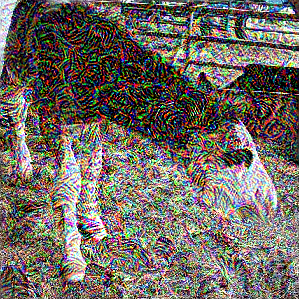

In [25]:
img_path = 'results/test_1.png'
test_img = image.load_img(img_path, target_size=(299, 299))
test_img

In [81]:
tf.logging.set_verbosity(0)

img_pic = image.load_img(base_image_path, target_size=(299, 299))
img = image.img_to_array(img_pic)
img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    #print('Processing image shape', shape)
    #img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    #upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    #same_size_original = resize_img(original_img, shape)
    #lost_detail = same_size_original - upscaled_shrunk_original_img

    #img += lost_detail
    #shrunk_original_img = resize_img(original_img, shape)

save_img(img, fname='results/test_1.png')

RuntimeError: sequence argument must have length equal to input rank

In [77]:
#img

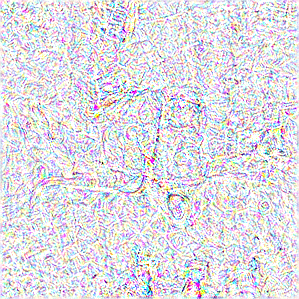

## Working

In [25]:
layer_name = 'mixed9'
layer_out = layer_dict[layer_name].output

In [26]:
layer_out

<tf.Tensor 'mixed9/concat:0' shape=(?, ?, ?, 2048) dtype=float32>

In [27]:
img_in = shrunk_original_img

In [28]:
img_in.shape

(1, 299, 299, 3)

In [31]:
new_acts = fetch_loss_and_grads_2([img_in])[0]

In [32]:
new_acts

0.05355437

In [ ]:
img_in

In [ ]:
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: img_in})

In [ ]:
layer_9_acts[0][5][0]

In [ ]:
new_acts[0][5][0]

## New Loss

In [ ]:
def get_loss(this_img):
    layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: this_img})
    flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)
    loss += euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))
    
    return loss

In [ ]:
get_loss(original_img)

In [ ]:
original_img.shape

In [ ]:
sess = K.get_session()
#my_graph = tf.get_default_graph()


In [ ]:
#my_graph.get_collection()

In [ ]:
sess

In [ ]:
model.input

In [ ]:
this_img = original_img

loss = K.variable(0.)
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{model.input: this_img})
flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)
loss += euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))

#K.clear_session()

In [ ]:
#loss

In [ ]:
#loss.eval(sess)

In [ ]:
#K.clear_session()

In [ ]:
#endpoints_v3

In [ ]:
model.input

In [ ]:
#img.shape

In [ ]:
layer_9_acts = layer_dict[layer_name].output

In [ ]:
layer_9_acts

In [ ]:
x.shape

In [ ]:
sess.run(bottlenecks_tensors[bottleneck_name],
                         {self.ends['input']: examples})

In [ ]:
#bottlenecks_tensors

In [ ]:
layer_9_cav

In [ ]:
img.shape

In [ ]:
model.input

In [ ]:
#sess.run(bottlenecks_tensors[bottleneck_name],{model.input: img})

In [ ]:
#layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: img})

#flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)

In [ ]:
#layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: x})

#flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)

#euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))

## Static functions

In [6]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

def get_bottleneck_tensors():
    """Add Inception bottlenecks and their pre-Relu versions to endpoints dict."""
    graph = tf.get_default_graph()
    bn_endpoints = {}
    for op in graph.get_operations():
        # change this below string to change which layers are considered bottlenecks
        # use 'ConcatV2' for InceptionV3
        # use 'MaxPool' for VGG16 (for example)
        if 'ConcatV2' in op.type:
            name = op.name.split('/')[0]
            bn_endpoints[name] = op.outputs[0]

    return bn_endpoints

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

bottlenecks_tensors = get_bottleneck_tensors()
bottleneck_name = 'mixed9'


#Process:
# Load the original image.
# Define a number of processing scales (i.e. image shapes), from smallest to largest.
# Resize the original image to the smallest scale.
# For every scale, starting with the smallest (i.e. current one):
    # Run gradient ascent
    # Upscale image to the next scale
    # Reinject the detail that was lost at upscaling time
# Stop when we are back to the original size.
#To obtain the detail lost during upscaling, we simply take the original image, shrink it down, upscale it,
# and compare the result to the (resized) original image.